<a href="https://colab.research.google.com/github/raamav/Text-Classification/blob/master/AmazonReviews_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on Amazon Reviews Dataset

The data set has more than 100,000 product reviews. The goal of the model is to correctly categorize these reviews by tehri sentiment (whether negative or positive)

Using an RNN architecture coomprising Bidirectional RNNs for this classification

<BR>

### 1. HOUSEKEEPING

In [2]:
!nvidia-smi

Wed Apr  8 11:56:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# STANDARD SET OF IMPORTS

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [0]:
# A FEW OTHER IMPORTS

import os
import datetime

import tensorflow_datasets as tfds

%load_ext tensorboard

In [5]:
print(tf.__version__)

2.2.0-rc2


In [6]:
# A QUICK LOOK AT THE GPU DEVICES

tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2. LOADING/EXPLORING DATA

In [7]:
datasets, info = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', with_info = True)

train_dataset = datasets['train']

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0.incompleteR6V6CJ/amazon_us_reviews-train.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet



Dataset amazon_us_reviews downloaded and prepared to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0. Subsequent calls will reuse this data.


In [8]:
info

tfds.core.DatasetInfo(
    name='amazon_us_reviews',
    version=0.1.0,
    description='Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others. Accordingly, we are releasing this data to further research in multiple disciplines related to understanding customer product experiences. Specifically, this dataset was constructed to represent a sample of customer evaluations and opinions, variation in the perception of a product across geographical regions, and promotional intent or bias in reviews.

Over 130+ million cus

The dataset has a **large** number of variables. We are interested in the `review_body` and the `star_rating` variables. The `star_rating` variable will be converted to the binary label.

In [9]:
print(train_dataset)

<DatasetV1Adapter shapes: {data: {customer_id: (), helpful_votes: (), marketplace: (), product_category: (), product_id: (), product_parent: (), product_title: (), review_body: (), review_date: (), review_headline: (), review_id: (), star_rating: (), total_votes: (), verified_purchase: (), vine: ()}}, types: {data: {customer_id: tf.string, helpful_votes: tf.int32, marketplace: tf.string, product_category: tf.string, product_id: tf.string, product_parent: tf.string, product_title: tf.string, review_body: tf.string, review_date: tf.string, review_headline: tf.string, review_id: tf.string, star_rating: tf.int32, total_votes: tf.int32, verified_purchase: tf.int64, vine: tf.int64}}>


A different sort of a format with a large number of variables

In [10]:
# GETTING THE SIZE OF THIS DATASET
# a bit of an unconventional format

len(list(train_dataset))

104975

In [0]:
# HOW MUCH DATA TO PREFETCH? 
# SPEEDS UP TRAINING. DON'T SET THIS TOO LOW ELSE ALL THE CLASSES WON'T GET GOOD REPRESENTATION
BUFFER_SIZE = 30000

# THE PARAM FOR MINI-BATCH GRADIENT DESCENT (ALSO RELATED TO THE # SAMPLES THAT CAN BE LOADED TO THE MEMORY AT A TIME)
BATCH_SIZE = 128

In [0]:
# SHUFFLING THE TRAINING DATA
train_dataset = train_dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration = False)

In [13]:
# EXPLORING A FEW DATA SAMPLES

for reviews in train_dataset.take(2):
  print(reviews)

{'data': {'customer_id': <tf.Tensor: shape=(), dtype=string, numpy=b'45082952'>, 'helpful_votes': <tf.Tensor: shape=(), dtype=int32, numpy=0>, 'marketplace': <tf.Tensor: shape=(), dtype=string, numpy=b'US'>, 'product_category': <tf.Tensor: shape=(), dtype=string, numpy=b'Mobile_Electronics'>, 'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'B00GMIKWMU'>, 'product_parent': <tf.Tensor: shape=(), dtype=string, numpy=b'111808354'>, 'product_title': <tf.Tensor: shape=(), dtype=string, numpy=b'Mulbess - Case Cover - Case Cover - Flip Stand Leather Cover with Elastic Hand Strap and Pen'>, 'review_body': <tf.Tensor: shape=(), dtype=string, numpy=b"Performs well.  Was a little weary about getting it since reviews weren't great, but my heart was set on an orange cover for my tablet...  It isn't the most sturdy cover, but it does a great job of protecting the tablet and doesn't cover any buttons or speakers.  I don't use the stand-up option regularly, but have tried it and it worked fine

In [14]:
# EXPLORING A FEW MORE DATA SAMPLES

for reviews in train_dataset.take(10):
  reviews_text = reviews['data']
  print(reviews_text.get('review_body').numpy())
  print(reviews_text.get('star_rating'))
  print(tf.where(reviews_text.get('star_rating')>3,1,0).numpy())
  print("\n")

b"Performs well.  Was a little weary about getting it since reviews weren't great, but my heart was set on an orange cover for my tablet...  It isn't the most sturdy cover, but it does a great job of protecting the tablet and doesn't cover any buttons or speakers.  I don't use the stand-up option regularly, but have tried it and it worked fine.  I was just careful to make sure I had the tablet in a place on the table where, if it fell, it would land on the table and not the floor.  I am happy with my purchase.  Love my color choice.  Does what I need it to do."
tf.Tensor(4, shape=(), dtype=int32)
1


b'First of all, this is a great little speaker, but if you are looking for really, and I mean, really low lows in your bass, this is not the one. The speaker sounds great and is clear, but there are limitations to size and power.<br />The only gripe I have is the color. The blue you see on your screen has been enhanced. The color blue I received is more of a baby blue, not to far off on th

### 3. Data Pre-Processing

In [15]:
# BUILD VOCABULARY
# CONTAINS DIFFERENT COMBINATION OF WORDS THATS THERE IN THE DATA

tokenizer = tfds.features.text.Tokenizer()

# USING SET TO GET UNIQUE WORDS
vocabulary_set = set()

for _, reviews in train_dataset.enumerate():
  review_text = reviews['data']
  reviews_tokens = tokenizer.tokenize(review_text.get('review_body').numpy())
  vocabulary_set.update(reviews_tokens)


vocab_size = len(vocabulary_set)

print("Vocab Size is :", vocab_size)




Vocab Size is : 73738


Notes:
1. Interesting to note that the total vocabulary is 73,738
2. `vocab_size` will be used in the embedding layer of the model to specfy the size of the vocabulary


In [0]:
# CONVERT THE TEXT INTO NUMERIC (INTEGER) VALUE

encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [95]:
# PRINTING OUT THE SET

#print(vocabulary_set)

print("Not printing the entire set")

Not printing the entire set


In [18]:
# ACCESSING FIRST 10 WORDS IN THE SET
# in general sets do not suport indexing or slicing

print(next(iter(vocabulary_set)))
print(next(iter(vocabulary_set)))

distinction
distinction


In [19]:
# PRINTING OUT THE REVIEW AND THE CORRESPONDING ENCODED TEXT

for reviews in train_dataset.take(5):
  review_text = reviews['data']
  print(review_text.get('review_body').numpy())
  encoded_example = encoder.encode(review_text.get('review_body').numpy())
  print(encoded_example)

b"Performs well.  Was a little weary about getting it since reviews weren't great, but my heart was set on an orange cover for my tablet...  It isn't the most sturdy cover, but it does a great job of protecting the tablet and doesn't cover any buttons or speakers.  I don't use the stand-up option regularly, but have tried it and it worked fine.  I was just careful to make sure I had the tablet in a place on the table where, if it fell, it would land on the table and not the floor.  I am happy with my purchase.  Love my color choice.  Does what I need it to do."
[2002, 12727, 7140, 5692, 20080, 67342, 71068, 43072, 70095, 31459, 44998, 33040, 33630, 52528, 31383, 70890, 33200, 42831, 19068, 33300, 67409, 64665, 34245, 52506, 70890, 52248, 29722, 69966, 33630, 12582, 4491, 43950, 34245, 31383, 70095, 48294, 5692, 52528, 44298, 8310, 23789, 12582, 52248, 68928, 57741, 33630, 34245, 15649, 11759, 44955, 12498, 35518, 57463, 33630, 45209, 12582, 24031, 72244, 64388, 5745, 31383, 54492, 3579

In [20]:
# USE F-STRINGS TO VISUALIZE THIS BETTER

for index in encoded_example:
  print('{} ----->{} '.format(index,encoder.decode([index])))

72103 ----->They 
23744 ----->r 
62066 ----->junk 


So far, we have taken text data **sample** and tokenized it (converted to integer value)


In [0]:
# FUNCTIONS TO TOKENIZE THE COMPLETE TRAINING DATA (21 min)

def encode(text_tensor, label_tensor):
  encoded_text = encoder.encode(text_tensor.numpy())
  label = tf.where( label_tensor >3 , 1, 0 )
  return encoded_text, label


In [0]:
# 

def encode_map_fn(tensor):

  text = tensor['data'].get('review_body')
  label = tensor['data'].get('star_rating')

  # THE encode FUNCTION IS CALLED IN THE NEXT STEP
  encoded_text, label = tf.py_function(encode, inp= [text,label], Tout= (tf.int64,tf.int32))

  encoded_text.set_shape([None])
  label.set_shape([])

  return encoded_text, label

In [0]:
ar_encoded_data = train_dataset.map(encode_map_fn)

In [24]:
# QUICKY CHECKING HOW THE OUTPUT LOOKS LIKE

# printing the first and the second feature for the first two records

for f0,f1 in ar_encoded_data.take(2):
  print(f0)
  print(f1)

tf.Tensor(
[ 2002 12727  7140  5692 20080 67342 71068 43072 70095 31459 44998 33040
 33630 52528 31383 70890 33200 42831 19068 33300 67409 64665 34245 52506
 70890 52248 29722 69966 33630 12582  4491 43950 34245 31383 70095 48294
  5692 52528 44298  8310 23789 12582 52248 68928 57741 33630 34245 15649
 11759 44955 12498 35518 57463 33630 45209 12582 24031 72244 64388  5745
 31383 54492 35793 70095 68928 70095 49103 54108 35518 42831 73094 32872
 64903 58449 51727 35518 24016 12582 52248  3481  5692 24870 33300 12582
 43458 37945 49644 70095 30173 70095 60212 57108 33300 12582 43458 68928
 27425 12582 45787 35518 23429 10520  8604 70890 70897 68974 70890 20617
 49941 49017 39397 35518 26933 70095 64903 21836], shape=(116,), dtype=int64)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(
[60238  8310 50208 23541 14657  5692 52528 20080  1896 31383 49644 49149
 70450 27202 52506 45060 68928 35518 18916 45060  5726 18656  3481 69956
 66559 23541 14657 27425 12582  9677 15953  1896 24039 52528 

In [0]:
# WE WANT A TEST DATA SIZE OF 10,000 (WHICH IS THE TAKE_SIZE)
TAKE_SIZE = 10000

# THE DATA IS SHUFFLED (for the reasona described earlier)
train_data = ar_encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
# THE DATA IS PADDED TO ENSURE THAT ALL THE SEQUENCES IN A BATCH ARE OF EQUAL LEN. RESULTANT LEN = MAX LENGTH
train_data = train_data.padded_batch(BATCH_SIZE)


# SIMILAR TO WHAT HAS BEEN DONE FOR TRAIN DATA
test_data = ar_encoded_data.take(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE)

# NOTE: CUSTOMISED PADDING APPROACHES MAY BE USED (DEPENDS ON THE TEXT)

In [0]:
# INCREMENTING vocab_size BY 1 TO ACCOUNT FOR THE PADDING VARIABLE

vocab_size += 1 

In [27]:
# HOW THE OUTPUT LOOKS LIKE AFTER PADDING IS DONE

sample_text, sample_labels = next(iter(test_data))

sample_text[0], sample_labels[0]

(<tf.Tensor: shape=(334,), dtype=int64, numpy=
 array([ 2002, 12727,  7140,  5692, 20080, 67342, 71068, 43072, 70095,
        31459, 44998, 33040, 33630, 52528, 31383, 70890, 33200, 42831,
        19068, 33300, 67409, 64665, 34245, 52506, 70890, 52248, 29722,
        69966, 33630, 12582,  4491, 43950, 34245, 31383, 70095, 48294,
         5692, 52528, 44298,  8310, 23789, 12582, 52248, 68928, 57741,
        33630, 34245, 15649, 11759, 44955, 12498, 35518, 57463, 33630,
        45209, 12582, 24031, 72244, 64388,  5745, 31383, 54492, 35793,
        70095, 68928, 70095, 49103, 54108, 35518, 42831, 73094, 32872,
        64903, 58449, 51727, 35518, 24016, 12582, 52248,  3481,  5692,
        24870, 33300, 12582, 43458, 37945, 49644, 70095, 30173, 70095,
        60212, 57108, 33300, 12582, 43458, 68928, 27425, 12582, 45787,
        35518, 23429, 10520,  8604, 70890, 70897, 68974, 70890, 20617,
        49941, 49017, 39397, 35518, 26933, 70095, 64903, 21836,     0,
            0,     0,     0,  

In [28]:
# A LOOK AT THE TARGET DISTRIBUTION (for the first 10 batches)

for f0,f1 in test_data.take(10):
  print(tf.unique_with_counts(f1)[2].numpy())

[86 42]
[83 45]
[42 86]
[49 79]
[46 82]
[45 83]
[97 31]
[43 85]
[82 46]
[45 83]


Summary:


### 4. Building/Executing the Model

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

**Quick Points:**

Embedding Layer:
1. `input_dim` = size of vocabuary +1 (incl. the padding)
2. `output_dim` = dimension of dense embedding. *Colloquially,* No. of Sequences, or `BATCH_SIZE` # Need more clarification
3. `input_length` = [OPTIONAL]. Ony needed if the `Flatten` and `Dense` layers will be comnnected upstream 
4. Input shape to this layer: 2D Tensor with shape `(batch_size, sequence_length)` # Need more clarification
5. Output shape to this layer :  3D Tensor of shape `(batch_size, sequences_length, output_dim)` #Need more clarification


Bidirectional LSTMs, Why?

In [0]:
# SPECIFYING THE MODEL ARCHITECTURE

# how are you specifying the imput shape?
# why isn't there a flatten layer between LSTM and Dense layers?

# BATCH_SIZE = 128 ; mini batch GD
# vocab_size = 73,738 + 1 ; total list of words + pad variable

model_1 = tf.keras.Sequential([
              keras.layers.Embedding(input_dim = vocab_size, output_dim =  BATCH_SIZE),
              keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences = True)),
              #keras.layers.Bidirectional(tf.keras.LSTM(64, return_sequences = True)),
              keras.layers.Bidirectional(keras.layers.LSTM(64)),

              
              keras.layers.Dense(64, activation = "relu"),
              keras.layers.Dense(64, activation = "relu"),
              #keras.layers.Dropout(0.2),
              
              keras.layers.Dense(1) # sigmoid - deliberately not chosen sigmoid
                                                      

])

In [70]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         9438592   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         263168    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 9,878,593
Trainable params: 9,878,593
Non-trainable params: 0
____________________________________________

In [0]:
# REMOVING TEMP LOGS

# unsure if this is needed now

#!rm -r /tmp/logs/

In [71]:
# COLAB GOOGLE DRIVE INTEGRATION 

# ONE TIME TASK, HENCE COMMENTED OUT

# from google.colab import drive
# drive.mount('/content/gdrive')

os.chdir('/content/gdrive/My Drive/models/')
os.getcwd()



'/content/gdrive/My Drive/models'

In [72]:
# LIST OF ALL FILES & FOLDERS IN THE DIRECTORY

os.listdir("../models/")

['final_sentiment_analysis.hdf5', 'amazon_reviews']

In [0]:
# CREATING A LOG DIRECTORY FOR MODEL OUTPUTS

logdir = os.path.join("../models/amazon_reviews/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [0]:

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)

In [0]:
# SAVING THE BEST MODEL

# unable to get this checkpoint to work

checkpoint = keras.callbacks.ModelCheckpoint(filepath = '../models/amazon_reviews/model_1_best_version.hdf5',
                                                verbose= 1, monitor = 'val_accuracy' ,save_best_only= True)

In [0]:
# COMPILE THE MODEL

model_1.compile(optimizer = "adam", loss = keras.losses.BinaryCrossentropy(from_logits= True),
                metrics = ['accuracy'])

In [77]:
# FITTING THE MODEL

# we don't have a separate validation set, needs to be implemented in V2

history = model_1.fit(train_data, epochs = 4, validation_data = test_data,
                      callacks = [tensorboard_callback, checkpoint]
                      )

Epoch 1/4
742/742 [==============================] - 270s 364ms/step - loss: 0.3446 - accuracy: 0.8446 - val_loss: 0.2793 - val_accuracy: 0.8844
Epoch 2/4
742/742 [==============================] - 268s 362ms/step - loss: 0.2384 - accuracy: 0.9021 - val_loss: 0.2653 - val_accuracy: 0.8886
Epoch 3/4
742/742 [==============================] - 269s 363ms/step - loss: 0.1912 - accuracy: 0.9229 - val_loss: 0.2773 - val_accuracy: 0.8866
Epoch 4/4
742/742 [==============================] - 270s 364ms/step - loss: 0.1539 - accuracy: 0.9401 - val_loss: 0.2825 - val_accuracy: 0.8894


In [78]:
# SAVING & LOADING THE MODEL

# SAVING THE LAST EPOCH (MAY NOT BE THE BEST) MODEL - NOT RECOMMENDED
try:
  model_1.save('../models/amazon_reviews/model_1.hdf5')
  print("Model saved successfully !")
except:
  print("Error ! Couldn't save the model")

# LOADING A SAVED MODEL 
#new_model = keras.models.load_model('../models/amazon_reviews/model_1.hdf5')

#new_model.evaluate(test_data)

Model saved successfully !


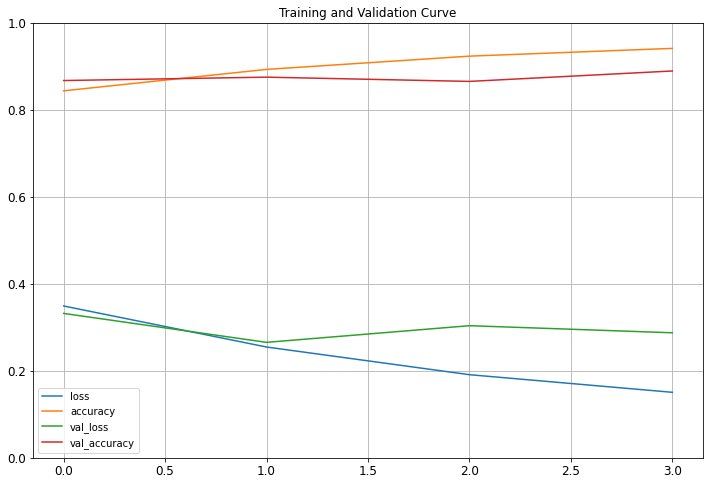

In [61]:
# TRAINING AND VALIDATION CURVES

import pandas as pd

pd.DataFrame(history.history).plot(figsize = (12,8))
plt.title("Training and Validation Curve")
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [79]:
# EVALUATING MODEL ON TEST DATA

model_1.evaluate(test_data)

79/79 [==============================] - 14s 181ms/step - loss: 0.2825 - accuracy: 0.8894


[0.28246352076530457, 0.8894000053405762]

In [80]:
# FOR THE 1ST BATCH, GETTING ACTUALS VS. PREDICTED

for f0,f1 in test_data.take(1):
  print(f1) # ACTUAL LABELS
  print(model_1.predict(f0)) # PREDICTED LABELS

tf.Tensor(
[1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1
 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1
 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0], shape=(128,), dtype=int32)
[[ 5.508557  ]
 [ 1.3464233 ]
 [ 4.327487  ]
 [-2.9006252 ]
 [-4.9546866 ]
 [ 4.290317  ]
 [-6.9611406 ]
 [ 6.5510287 ]
 [ 4.9016633 ]
 [ 5.1762767 ]
 [ 3.4483845 ]
 [ 5.6966376 ]
 [-3.92148   ]
 [ 4.2923574 ]
 [ 3.6824882 ]
 [-3.9144773 ]
 [ 3.4217014 ]
 [ 5.065005  ]
 [ 4.33899   ]
 [ 0.9974472 ]
 [ 5.1792054 ]
 [-0.73150474]
 [ 4.369603  ]
 [-1.3048934 ]
 [ 0.683337  ]
 [-7.325704  ]
 [ 5.49012   ]
 [ 4.980684  ]
 [-2.704315  ]
 [ 6.1290402 ]
 [ 5.8597603 ]
 [ 0.02224104]
 [ 3.8220608 ]
 [-6.8725576 ]
 [ 5.123527  ]
 [ 5.0854926 ]
 [ 6.4982514 ]
 [ 5.6125627 ]
 [ 5.6422276 ]
 [ 5.502891  ]
 [ 2.686019  ]
 [-1.6420789 ]
 [-2.987428  ]
 [ 1.4388939 ]
 [-4.80111   ]
 [ 0.8282491 ]
 [-3.48305

In [0]:
# PERFORMING INFERENCE ON THE MODEL

def pad_to_size(vec,size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
# INFERENCE FUNCTION; AKES IN 'PLAIN ENGLISH TEXT'

def predict_fn(pred_txt, model):
  encoded_pred_txt = encoder.encode(pred_txt)
  print(encoded_pred_txt)
  print("\n")

  encoded_pred_txt = pad_to_size(encoded_pred_txt,32)
  print(encoded_pred_txt)

  encoded_pred_txt = tf.cast(encoded_pred_txt,tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_pred_txt,0))

  return predictions

In [90]:
# EXECUTING THE INFERENCE FUNCTION (e.g 1)

pred_txt = ('This watch is pretty bad. Color and dial look pathetic')

predictions = predict_fn(pred_txt, model_1)

print(predictions)

[60956, 35813, 14657, 71501, 38609, 15864, 68928, 7209, 53196, 56443]


[60956, 35813, 14657, 71501, 38609, 15864, 68928, 7209, 53196, 56443, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[-3.4598305]]


In [94]:
# EXECUTING THE INFERENCE FUNCTION (e.g 2)

pred_txt = ('Color and Dial not as advertised. Not super happy')

predictions = predict_fn(pred_txt, model_1)

print(predictions)

[15864, 68928, 32632, 27425, 65721, 61231, 24304, 47699, 10520]


[15864, 68928, 32632, 27425, 65721, 61231, 24304, 47699, 10520, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[-4.211573]]


In [92]:
# EXECUTING THE INFERENCE FUNCTION (e.g 3)

pred_txt = ('Amazing Product. Fast Delivery. Nice Packing')

predictions = predict_fn(pred_txt, model_1)

print(predictions)

[47890, 35361, 5299, 47356, 8492, 11992]


[47890, 35361, 5299, 47356, 8492, 11992, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[6.498644]]


In [93]:
# EXECUTING THE INFERENCE FUNCTION (e.g 4)

pred_txt = ('Nice Product. Packing could have been better')

predictions = predict_fn(pred_txt, model_1)

print(predictions)

[8492, 35361, 11992, 31190, 54492, 35451, 5778]


[8492, 35361, 11992, 31190, 54492, 35451, 5778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[2.17375]]


**Comments**
1. The model (final epoch) seems to be overfitting. The 2nd and 3rd epochs seem to be the best performing ones 
2. Will be attemptng strategies to reduce overfitting in the next section

In [63]:
# CHECKING THE models/amazon_reviews DIRECTORY FOR THE VERSIONS OF THE MODEL
#!ls -alrt /models/amazon_reviews

ls: cannot access '/models/amazon_reviews': No such file or directory


In [0]:
# LOADING THE BEST VERSION OF THE MODEL

#model_1_best = keras.models.load_model(filepath = '/amazon_reviews/model1_best_version.hdf5')

In [0]:
# EVALUTING THE "BEST" MODEL ON TEST DATA

#model1_best.evaluate(test_data)

In [0]:
# HOW MUCH GPU MEMORY HAS BEEN USED

!nvidia-smi

### 5. Tuning the Model